# Script Overview

This self-contained Jupyter notebook implements every step of a neural network from scratch—without importing any code from `src/`. All functions (initialization, forward pass, backward pass, optimization, metrics, and plotting) are defined inline, making this notebook longer and more detailed for users who enjoy exploring every component in one place.

**Notebook structure:**
1. **Neural-Network Components (All Inline)**  
   - Weight/bias initialization routines  
   - Activation functions (ReLU, Sigmoid and more)  
   - Loss function with L2 regularization  
   - Forward and backward propagation loops  
   - Adam optimizer implementation and normal gradient descend 
2. **Data Loading & Preprocessing**  
   - Load the Customer Churn dataset  
   - Split into train/validation/test sets  
   - Scale features using standard normalization 
3. **Hyperparameter showcase**  
   - Learning rates, hidden-layer sizes, batch sizes, regularization strengths 
4. **Training & Monitoring**  
   - Detailed training loop with per-epoch console logging  
   - Matplotlib plots of loss and accuracy curves inline  

5. **Evaluation & Visualization**  
   - Compute and display test accuracy, confusion matrix, and ROC curve  
   - Inline code to plot ROC and precision-recall curves  

By running this notebook from top to bottom, you will reproduce the full diabetes-prediction pipeline—with maximum transparency into every mathematical and coding detail. 


## Librarys

In [2]:
import pandas as pd 
import numpy as np 
import math
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

## Lets star making the blocks for the Neural Network

In [3]:
class ReLu:
    """Rectified Linear Unit (ReLU) activation function.

    Applies the ReLU operation during forward propagation and computes
    its derivative during backpropagation.

    Usage:
        relu = ReLu()
        a = relu(z)             # forward: max(0, z)
        da_dz = relu(z, False)  # backward: derivative w.r.t. z
    """

    def __call__(self, z, forw_prop=True):
        """Compute ReLU activation or its derivative.

        Args:
            z (array-like): Input array of pre-activation values.
            forw_prop (bool, optional): If True (default), returns the
                forward pass ReLU outputs; if False, returns the derivative
                dReLU/dz for backpropagation.

        Returns:
            np.ndarray: Element-wise ReLU activations (if `forw_prop=True`)
                or element-wise gradients (if `forw_prop=False`).
        """

        z = np.asarray(z, dtype=np.float64)
        
        if forw_prop:
            return np.maximum(0, z)
        dz = np.zeros_like(z)
        dz[z > 0] = 1
        return dz

class Sigmoid:
    """Sigmoid activation function.

    Computes the logistic sigmoid during forward propagation and its
    derivative during backpropagation.

    Usage:
        sig = Sigmoid()
        a = sig(z)             # forward: 1 / (1 + exp(-z))
        da_dz = sig(z, False)  # backward: sigmoid(z) * (1 − sigmoid(z))
    """

    def __call__(self, z, forw_prop=True):
        """Compute sigmoid activation or its gradient.

        Args:
            z (array-like): Input pre-activation values.
            forw_prop (bool, optional): If True (default), returns the
                sigmoid outputs; if False, returns the derivative
                dσ/dz for backpropagation.

        Returns:
            np.ndarray: Element-wise sigmoid activations (if `forw_prop=True`)
                or gradients (if `forw_prop=False`).
        """

        z = np.asarray(z, dtype=np.float64)
        z = np.clip(z, -500, 500)

        sigm = 1 / (1 + np.exp(-z))
        if forw_prop:
            return sigm
        return sigm * (1 - sigm)
    
class LeakyReLu:
    """Leaky Rectified Linear Unit (Leaky ReLU) activation function,
    sin __init__, con pendiente α fija.

    Forward:  f(z) = z     if z > 0
                    α·z    otherwise

    Backward: f'(z) = 1     if z > 0
                    α       otherwise
    """

    # pendiente en la parte negativa
    alpha = 0.01

    def __call__(self, z, forw_prop: bool = True):
        """
        Args:
            z (array-like): pre-activations.
            forw_prop (bool): True → forward; False → derivada.
        """
        z = np.asarray(z, dtype=np.float64)

        if forw_prop:
            return np.where(z > 0, z, self.alpha * z)
        
        # Derivate
        dz = np.ones_like(z)
        dz[z < 0] = self.alpha
        return dz
    

class Tanh:
    """Hyperbolic tangent (tanh) activation function.

    Computes the tanh activation during forward propagation and its
    derivative during backpropagation.

    Usage:
        tanh = Tanh()
        a = tanh(z)             # forward: tanh(z)
        da_dz = tanh(z, False)  # backward: 1 − tanh(z)**2
    """

    def __call__(self, z, forw_prop=True):
        """Compute tanh activation or its gradient.

        Args:
            z (array-like): Input pre-activation values.
            forw_prop (bool, optional): If True (default), returns the
                tanh outputs; if False, returns the derivative
                d(tanh)/dz for backpropagation.

        Returns:
            np.ndarray: Element-wise tanh activations (if `forw_prop=True`)
                or gradients (if `forw_prop=False`).
        """

        z = np.asarray(z, dtype=np.float64)
        z = np.clip(z, -500, 500)

        tan = np.tanh(z)
        if forw_prop:
            return tan
        return 1 - tan**2

class Softmax:
    """Softmax activation function.

    Computes the softmax probabilities during forward propagation and the
    corresponding Jacobian matrices during backpropagation.

    Usage:
        softmax = Softmax()
        A = softmax(z)             # forward: softmax across each column
        J = softmax(z, False)      # backward: Jacobian(s) dA/dz
    """

    def __call__(self, z, forw_prop=True):
        """Compute softmax activation or its Jacobian.

        Args:
            z (np.ndarray): Input array of shape (n, m), where each column
                is a set of pre-activation values for n classes and m examples.
            forw_prop (bool, optional): If True (default), returns the softmax
                outputs; if False, returns the Jacobian matrix for each example.

        Returns:
            np.ndarray:
                - If `forw_prop=True`: array of shape (n, m) with softmax
                  probabilities for each column.
                - If `forw_prop=False`:
                    - shape (n, n) if `z` is 1D (n,) (single example),
                    - shape (m, n, n) if `z` is 2D (n, m) (one Jacobian per column).
        """

        shift = z - np.max(z, axis=0, keepdims=True)
        exp_z = np.exp(shift)
        A = exp_z / np.sum(exp_z, axis=0, keepdims=True)
        if forw_prop:
            return A
        if z.ndim == 1:
            return np.diag(A) - np.outer(A, A)
        
        n, m = A.shape

        jacobianas = np.zeros((m, n, n))
        for i in range(m):
            ai = A[:, i]
            jacobianas[i] = np.diag(ai) - np.outer(ai, ai)
        return jacobianas


def random_mini_batches(X, Y, mini_batch_size=64, seed=None):
    """Generate a list of random mini-batches from (X, Y).

    Args:
        X (np.ndarray): Input data of shape (n_x, m), where m is the number of examples.
        Y (np.ndarray): Labels of shape (n_y, m) or (m,); will be reshaped to (1, m) if needed.
        mini_batch_size (int, optional): Size of each mini-batch. Defaults to 64.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        list of tuples: A list where each element is a tuple
            `(mini_batch_X, mini_batch_Y)` with shapes
            `(n_x, mini_batch_size)` and `(n_y, mini_batch_size)` (except the last batch
            which may be smaller if m is not divisible by `mini_batch_size`).
    """

    m = X.shape[1]
    if Y.ndim == 1:
        Y = Y.reshape(1, m)

    rng = np.random.RandomState(seed)
    permutation = rng.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    mini_batches = []
    num_complete = math.floor(m / mini_batch_size)
    for k in range(num_complete):
        start = k * mini_batch_size
        end   = start + mini_batch_size

        mini_batches.append((shuffled_X[:, start:end],shuffled_Y[:, start:end]))

    if m % mini_batch_size != 0:
        start = num_complete * mini_batch_size
        mini_batches.append((shuffled_X[:, start: ],shuffled_Y[:, start: ]))

    return mini_batches


def iniciar_parametros(shape_nn:list , inicialization='Rand' , he_init = None , escala = 0.01):
    """Initialize neural network parameters.

    Supports standard random scaling or selective He initialization.

    Args:
        shape_nn (list of int): Layer sizes including input, e.g. [n_x, n_h1, ..., n_y].
        initialization (str, optional): 
            - 'Rand': random normal * scale  
            - 'He_Normal': He initialization on layers flagged in `he_init`.  
            Defaults to 'Rand'.
        he_init (list of bool, optional): Flags (one per layer transition) indicating
            which layers use He initialization when `initialization='He_Normal'`.
            Length must be `len(shape_nn) - 1`. Defaults to None.
        scale (float, optional): Scaling factor for the 'Rand' method. Defaults to 0.01.

    Returns:
        dict or str:
            If successful, returns a dict with keys:
                W{i} (ndarray): weights of layer i, shape (shape_nn[i], shape_nn[i-1])
                b{i} (ndarray): biases of layer i, shape (shape_nn[i], 1)
            If invalid options are provided, returns an error message string.

    Raises:
        ValueError: 
            - If `initialization` is not 'Rand' or 'He_Normal'.
            - If `he_init` length mismatches `len(shape_nn) - 1` when using 'He_Normal'.
    """

    parameters = {}

    dim_layer = len(shape_nn)


    if inicialization == 'He_Normal' and he_init == None:
        bools = [False] + [1 for _ in range(len(shape_nn)-1)]
        he_init = bools[1:]
    elif inicialization == 'He_Normal' and isinstance(he_init , list):
        bools = [False] + [bool(x) for x in he_init]
    elif inicialization == 'He_Normal' and not(isinstance(he_init , list)):
        raise ValueError('He_init debe ser una lista')

    if inicialization == 'Rand':
        for i in range(1, dim_layer):
            parameters['W' + str(i)] = np.random.randn(shape_nn[i],shape_nn[i-1]) * escala
            parameters['b' + str(i)] = np.zeros((shape_nn[i], 1))

    elif inicialization == 'He_Normal':
        if len(he_init) != (len(shape_nn)-1):
            raise ValueError('`he_init` debe tener longitud igual a `len(shape_nn) - 1`')
        
        for i in range(1, dim_layer):
            if bools[i]:
                parameters['W' + str(i)] = np.random.randn(shape_nn[i],shape_nn[i-1]) * np.sqrt(2/shape_nn[i-1])
                parameters['b' + str(i)] = np.zeros((shape_nn[i], 1))
            else:
                parameters['W' + str(i)] = np.random.randn(shape_nn[i],shape_nn[i-1]) * escala
                parameters['b' + str(i)] = np.zeros((shape_nn[i], 1))
    else:
        raise ValueError("`inicialization` debe ser 'Rand' o 'He_Normal'")
        
    return parameters


def one_layer_forward(A_prev , w , b , activation):
    """Perform forward propagation for a single neural network layer.

    Args:
        A_prev (np.ndarray): Activations from the previous layer,
            shape (size_prev, m), where m is the batch size.
        w (np.ndarray): Weights matrix for the current layer,
            shape (size_current, size_prev).
        b (np.ndarray): Bias vector for the current layer,
            shape (size_current, 1).
        activation (str): Name of the activation function to apply.
            Supported values: 'relu', 'sigmoid', 'tanh', 'softmax'.

    Returns:
        tuple:
            A (np.ndarray): Activations for the current layer,
                shape (size_current, m).
            forward_vars (tuple): Cached values (Z, w, b) for use in backpropagation.

    Raises:
        KeyError: If `activation` is not one of the supported keys.
    """

    activaciones = {
    'relu': ReLu(),
    'sigmoid': Sigmoid(),
    'tanh': Tanh(),
    'leaky_relu': LeakyReLu(),
    'softmax': Softmax()}

    Z = w @ A_prev + b
    if activation == 'relu':
        A = activaciones['relu'](Z)

    elif activation == 'tanh':
        A = activaciones['tanh'](Z)

    elif activation == 'sigmoid':
        A = activaciones['sigmoid'](Z)

    elif activation == 'softmax':
        A = activaciones['softmax'](Z)

    forward_vars = (Z , w , b)

    return A , forward_vars


def forward_pass(X , parameters , activations):
    """Perform a full forward pass through a multi-layer neural network.

    Args:
        X (np.ndarray): Input data of shape (n_x, m), where m is the number of examples.
        parameters (dict): Dictionary containing network parameters:
            - 'W{i}' (np.ndarray): weight matrix for layer i.
            - 'b{i}' (np.ndarray): bias vector for layer i.
          There should be 2·L entries for an L-layer network.
        activations (list of str): List of activation names to apply at each layer,
            length L. Supported: 'relu', 'sigmoid', 'tanh', 'softmax'.

    Returns:
        tuple:
            A_final (np.ndarray): Activations from the last layer, shape (n_y, m).
            caches (dict): Cached values for backpropagation. Contains for each layer i:
                - 'A{i-1}': activations from previous layer,
                - 'Z{i}': pre-activation,
                - 'W{i}', 'b{i}': parameters for layer i,
                - 'A{i}': activations of layer i.

    Raises:
        ValueError: If the number of activations does not match the number of layers.
    """

    A = X 
    layers = len(parameters) // 2 
    if len(activations) != layers: 
        return f'El numero de funciones de activacion no coincide'
    
    caches = {}
    caches['A' + str(0)] = X

    for i in range(1, layers):
        A_prev = A
        A ,  forward_vars =  one_layer_forward(A_prev , parameters['W' + str(i)] , parameters['b' + str(i)] , activations[i-1])
        caches['W' + str(i)] = forward_vars[1]
        caches['b' + str(i)] = forward_vars[2]
        caches['Z' + str(i)] = forward_vars[0]
        caches['A' + str(i)] = A
    

    A_final , forward_vars_final =  one_layer_forward(A , parameters['W' + str(layers)] , parameters['b' + str(layers)] , activations[layers-1])
    caches['W' + str(layers)] = forward_vars_final[1]
    caches['b' + str(layers)] = forward_vars_final[2]
    caches['Z' + str(layers)] = forward_vars_final[0]

    return A_final , caches 


def compute_cost(A_final , labels , tipe , caches ,regularization = False , lambda_reg = None ):
    """Compute the loss between predicted probabilities and true labels, with optional L2 regularization.

    Supports binary cross-entropy for two-class problems or categorical
    cross-entropy for multi-class problems. When `regularization=True`, adds
    an L2 penalty term λ/(2m)·∑‖W‖² over all weight matrices stored in `caches`.

    Args:
        A_final (np.ndarray): Predicted probabilities, shape (n_y, m).
        labels (np.ndarray): True labels, shape (n_y, m) or (m,); will be
            reshaped to (1, m) if necessary.
        tipe (str): Type of cost to compute:
            - 'BinaryCrossEntropy': binary cross-entropy loss.
            - 'CrossEntropy': categorical cross-entropy loss.
        caches (dict, optional): Dictionary of cached values from forward pass.
            Used to extract weight matrices 'W1', 'W2', … when `regularization=True`.
        regularization (bool, optional): If True, include L2 penalty. Defaults to False.
        lambda_reg (float, optional): Regularization strength λ for L2 penalty.
            Must be ≥ 0. Defaults to 0.0.

    Returns:
        float: The scalar loss value (including regularization term if enabled).

    Raises:
        ValueError: If `tipe` is not one of the supported cost types.
    """

    # Ensure labels are shape (n_y, m)
    if labels.ndim == 1:
        labels = labels.reshape(1, -1)

    m = labels.shape[1]
    eps = 1e-15
    A_safe = np.clip(A_final, eps, 1 - eps)

    # Compute base cost
    if tipe == 'BinaryCrossEntropy':
        logprobs = (labels * np.log(A_safe) +
                    (1 - labels) * np.log(1 - A_safe))
        cost = - (1 / m) * np.sum(logprobs)

    elif tipe == 'CrossEntropy':
        logprobs = labels * np.log(A_safe)
        cost = - (1 / m) * np.sum(logprobs)

    else:
        raise ValueError("`tipe` must be 'BinaryCrossEntropy' or 'CrossEntropy'")

    # Add L2 regularization term if requested
    if regularization:
        if lambda_reg < 0:
            raise ValueError("`lambda_reg` must be non-negative for L2 regularization")
        
        if caches is None:
            raise ValueError("`caches` must be provided when using regularization")
        
        l2_sum = sum(np.sum(W**2) for name, W in caches.items() if name.startswith('W'))
        cost += (lambda_reg / (2 * m)) * l2_sum

    return float(np.squeeze(cost))
    


def back_propagation(A_fianl , labels , activations , caches , regularization = False , lambda_reg = None):
    """Perform backpropagation through a multi-layer neural network, with optional L2 regularization.

    Computes gradients of the loss with respect to parameters for each layer,
    assuming the final activation is either sigmoid (binary classification)
    or softmax (multi-class classification). When `regularization='L2'`, adds
    the derivative of the L2 penalty (λ/m·W) to each dW.

    Args:
        A_final (np.ndarray): Output activations from the last layer, shape (n_y, m).
        labels (np.ndarray): True labels, shape (n_y, m).
        activations (list of str): Activation names for each layer, length L.
            Supported: 'relu', 'sigmoid', 'tanh', 'softmax' (only for final layer).
        caches (dict): Cached forward values from `forward_pass`, containing for
            each layer i:
            - 'Z{i}': pre-activation, shape (n_i, m)
            - 'W{i}': weights, shape (n_i, n_{i-1})
            - 'A{i}': activations, shape (n_i, m)
        regularization (bool or str, optional): If 'L2', apply L2 regularization.
            If False (default), no regularization.
        lambda_reg (float, optional): Regularization strength λ for L2 penalty.
            Must be ≥ 0. Default is 0.0.

    Returns:
        dict: Gradients with keys for each layer i:
            - 'dZ{i}': gradient of loss w.r.t. Z{i}
            - 'dW{i}': gradient of loss w.r.t. W{i} (including λ·W/m if L2)
            - 'db{i}': gradient of loss w.r.t. b{i}

    Raises:
        ValueError: If the final activation is not 'sigmoid' or 'softmax',
                    or if `lambda_reg` < 0 when using L2 regularization.
    """

    activation_names = {'relu': ReLu() , 'sigmoid': Sigmoid() , 'tanh': Tanh() ,'leaky_relu': LeakyReLu()}
    back_prop_caches = {}
    layers = len(activations)
    m = labels.shape[1]

    if regularization == 'L2' and (lambda_reg is None or lambda_reg < 0):
        raise ValueError("Para L2 regularization, lambda_reg debe ser ≥ 0")
    
    #Compute Last Layer derivates:
    if activations[-1] in ('sigmoid', 'softmax'):
        dZ_fin = A_fianl - labels
        dW_fin = 1/m * (dZ_fin @ caches['A' + str(layers-1)].T)

        if regularization == 'L2' :
            dW_fin = dW_fin + (lambda_reg/m) * caches['W' + str(layers)]

        db_fin = 1/m * np.sum(dZ_fin , axis=1 , keepdims=True)

        back_prop_caches['dZ' + str(layers)]  , back_prop_caches['dW' + str(layers)] , back_prop_caches['db' + str(layers)] = dZ_fin ,dW_fin ,db_fin

    else:
        return f'La funcion de activacion final no es valida'
        
    # Calcular gradientes de todas las capas ocultas: 
    for i in range(layers-1 ,0 , -1):
        act_actual = activations[i-1]
        dA_i = caches['W' + str(i+1)].T @ back_prop_caches['dZ' + str(i+1)]
        dZ_i = dA_i * activation_names[act_actual](caches['Z' + str(i)] , forw_prop=False )
        dW_i = 1/m * (dZ_i @ caches['A' + str(i-1)].T)

        if regularization == 'L2':
            dW_i = dW_i + (lambda_reg/m) * caches['W' + str(i)]

        db_i = 1/m * np.sum(dZ_i , axis=1 , keepdims=True)

        back_prop_caches['dZ' + str(i)]  , back_prop_caches['dW' + str(i)]  , back_prop_caches['db' + str(i)] = dZ_i , dW_i ,db_i
    
    return back_prop_caches 

def update_gd_parameters(parameters, back_caches, lr):
    """Update network parameters using vanilla gradient descent.

    Args:
        parameters (dict): Current parameters of the network, with keys:
            - 'W{i}' (np.ndarray): weight matrix for layer i.
            - 'b{i}' (np.ndarray): bias vector for layer i.
        back_caches (dict): Gradients from backpropagation, with keys:
            - 'dW{i}' (np.ndarray): gradient of loss w.r.t. W{i}.
            - 'db{i}' (np.ndarray): gradient of loss w.r.t. b{i}.
        lr (float): Learning rate.

    Returns:
        dict: Updated parameters after one gradient descent step. Each
            W{i} and b{i} is adjusted by subtracting lr * gradient.
    """

    parameters = copy.deepcopy(parameters)
    layers = len(parameters) // 2 

    for l in range(layers):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - lr * back_caches["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - lr * back_caches["db" + str(l + 1)]

    return parameters


def iniciar_params_adam(parameters):
    """Initialize Adam optimizer’s first and second moment variables.

    Args:
        parameters (dict): Network parameters with keys:
            - 'W{i}' (np.ndarray): weight matrix for layer i.
            - 'b{i}' (np.ndarray): bias vector for layer i.
          There should be 2·L entries for an L-layer network.

    Returns:
        tuple of dict:
            v (dict): Initialized first moment estimates with keys
                'dW{i}' and 'db{i}', each an array of zeros matching
                the shape of the corresponding parameter.
            s (dict): Initialized second moment estimates with keys
                'dW{i}' and 'db{i}', each an array of zeros matching
                the shape of the corresponding parameter.

    """
     
    layers  = len(parameters) // 2 
    v = {}
    s = {}

    for l in range(1, layers + 1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    return v, s



def adam(back_caches , parameters , v , s , t , learning_rate = 0.01 , beta1 = 0.9, beta2 = 0.999 ,epsilon = 1e-8):
    """Update parameters using the Adam optimization algorithm.

    Applies bias-corrected first and second moment estimates to perform
    an adaptive gradient update on each parameter.

    Args:
        back_caches (dict): Gradients from backprop, with keys:
            - 'dW{i}' and 'db{i}' for each layer i.
        parameters (dict): Current network parameters, with keys:
            - 'W{i}' and 'b{i}' for each layer i.
        v (dict): Exponential moving averages of past gradients (first moment).
        s (dict): Exponential moving averages of past squared gradients (second moment).
        t (int): Time step (iteration count) for bias correction.
        learning_rate (float, optional): Step size. Defaults to 0.01.
        beta1 (float, optional): Decay rate for the first moment. Defaults to 0.9.
        beta2 (float, optional): Decay rate for the second moment. Defaults to 0.999.
        epsilon (float, optional): Small constant to prevent division by zero. Defaults to 1e-8.

    Returns:
        dict: Updated parameters dictionary with the same keys as `parameters`.

    """

    parameters = copy.deepcopy(parameters)
    v_corrected = {}
    s_corrected = {}
    layers = len(parameters) // 2
    
    for i in range(1, layers + 1):
        v["dW" + str(i)] = beta1*(v["dW" + str(i)]) + (1-beta1) * back_caches["dW" + str(i)]
        v["db" + str(i)] = beta1*(v["db" + str(i)]) + (1-beta1) * back_caches["db" + str(i)]

        s["dW" + str(i)] = beta2*(s["dW" + str(i)]) + (1-beta2) * (back_caches["dW" + str(i)]**(2))
        s["db" + str(i)] = beta2*(s["db" + str(i)]) + (1-beta2) * (back_caches["db" + str(i)]**(2))

        v_corrected["dW" + str(i)] = v["dW" + str(i)] / (1 - beta1**t)
        v_corrected["db" + str(i)] = v["db" + str(i)] / (1 - beta1**t)

        s_corrected["dW" + str(i)] = s["dW" + str(i)] / (1 - beta2**t)
        s_corrected["db" + str(i)] = s["db" + str(i)] / (1 - beta2**t)

        
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate*(v_corrected["dW" + str(i)]/( np.sqrt( s_corrected["dW"+str(i)] ) + epsilon ))
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate*(v_corrected["db" + str(i)]/( np.sqrt( s_corrected["db"+str(i)] ) + epsilon ))
    
    return parameters 


def learning_decay(learning_rate0, epoch_num, decay_rate):
    """Compute an updated learning rate using inverse time decay.

    The learning rate is scaled by 1 / (1 + decay_rate * epoch_num), so it
    decreases over epochs.

    Args:
        learning_rate0 (float): Initial learning rate before decay.
        epoch_num (int): Current epoch index (often starting at 0).
        decay_rate (float): Decay coefficient controlling the rate of decrease.

    Returns:
        float: Decayed learning rate:
            learning_rate0 / (1 + decay_rate * epoch_num)
    """

    learning_rate = 1 / ((1 + decay_rate * epoch_num)) * learning_rate0
    return learning_rate


def predict(X , y , parameters, activations , train = False , reg = False , lambda_reg=None , way=None):
    """Make predictions with a trained binary classification network and evaluate performance.

    Args:
        X (np.ndarray): Input features of shape (n_x, m), where m is the number of examples.
        y (np.ndarray): True binary labels of shape (1, m) or (m,); will be compared element-wise.
        parameters (dict): Learned network parameters (weights and biases).
        activations (list of str): Activation names for each layer, length L.
        train (bool, optional): If False (default), prints cost and accuracy on the given data
            and returns predictions; if True, returns only accuracy (for training).

    Returns:
        np.ndarray or float:
            - If `train=False`: Returns `preds`, a (1, m) array of binary predictions {0,1}.
            - If `train=True`: Returns `accuracy`, the fraction of correct predictions.
    """

    cost_total = 0
    A_pred, _ = forward_pass(X, parameters, activations ) 

    if reg == False:
        cost_total = cost_total + compute_cost(A_pred , y , 'BinaryCrossEntropy', parameters)
    elif reg == 'L2':
        cost_total = cost_total + compute_cost(A_pred , y , 'BinaryCrossEntropy', parameters , reg , lambda_reg)
        
    preds = (A_pred > 0.5).astype(int) 
    accuracy = np.mean(preds == y) 

    if train == False and way== 'val':
        print(f"En validacion el modelo logro: cost = {cost_total:.6f} — accuracy = {accuracy*100:.2f}%")
        return preds
    elif train == False and way== 'test':
        print(f"En testeo el modelo logro: cost = {cost_total:.6f} — accuracy = {accuracy*100:.2f}%")
        return preds
    else:
        return accuracy



### Lets import a df to train the neural network we just created and also implement a manual standarization for numerical and categorical features and manual split into train val test

In [7]:
data_frame = pd.read_csv('../Data/Customer-Churn-Records.csv')

X = data_frame.drop(columns='Exited')
y = data_frame['Exited']


numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

## Transformar datos: 

def manual_standardize(df, column):
    """Standardize a DataFrame column to zero mean and unit variance in-place.

    Computes the column’s mean and population standard deviation (ddof=0)
    then replaces values with their z-scores.

    Args:
        df (pd.DataFrame): DataFrame containing the target column.
        column (str): Name of the column to standardize.

    Returns:
        None: Modifies `df[column]` in place.
    """

    mean = df[column].mean()
    std  = df[column].std(ddof=0)  
    df[column] = (df[column] - mean) / std
    return 

def label_encoder(df, column, encoder=None):
    
    """Encode categorical values in a DataFrame column as integer labels.

    Fits (or uses) a scikit-learn LabelEncoder to transform the specified column
    in-place, converting each unique category to an integer.

    Args:
        df (pd.DataFrame): DataFrame containing the column to encode.
        column (str): Name of the column with categorical values.
        encoder (LabelEncoder, optional): Pre-instantiated encoder to use.
            If None (default), a new LabelEncoder is created and fitted.

    Returns:
        LabelEncoder: The fitted encoder instance, useful for inverse transforms
        or applying the same mapping to other datasets.
    """

    if encoder is None:
        encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column].astype(str))
    return encoder

encoders = {}
for col in X.columns:
    if col in numeric_cols:
        manual_standardize(X, col)
    elif col in categorical_cols:
        encoders[col] = label_encoder(X, col)
    else:
        pass

# Change to Arrays 
X_array =  X.to_numpy()
Y_array =  y.to_numpy()

# Trian test split 
def train_val_test_split(X, y, train_pct, val_pct, test_pct):
    """Split datasets into training, validation, and test sets by specified proportions.

    Converts inputs to NumPy arrays, ensures correct shapes, and splits along the
    first axis (samples). Supports 1D or row-vector `y`.

    Args:
        X (array-like): Features of shape (m, n) or (n, m), where m is number of samples.
        y (array-like): Labels of shape (m,) or (1, m) or (m, 1).
        train_pct (float): Relative proportion for the training set.
        val_pct (float): Relative proportion for the validation set.
        test_pct (float): Relative proportion for the test set.

    Returns:
        tuple:
            X_train (np.ndarray): Training features.
            X_val (np.ndarray): Validation features.
            X_test (np.ndarray): Test features.
            y_train (np.ndarray): Training labels.
            y_val (np.ndarray): Validation labels.
            y_test (np.ndarray): Test labels.

    Raises:
        ValueError: If `y` has more than 2 dimensions.
    """
    
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    if X.ndim == 2 and X.shape[0] < X.shape[1]:
        X = X.T

    if y.ndim == 2:
        if y.shape[0] == 1:
            y = y.flatten()
        elif y.shape[1] == 1:
            y = y.reshape(-1)
    elif y.ndim != 1:
        raise ValueError(f"y debe ser 1-D o (1, m); llegó con ndim={y.ndim}")
    
    total = train_pct + val_pct + test_pct
    train_prop = train_pct / total
    val_prop = val_pct / total

    n = X.shape[0]
    idx = np.arange(n)

    train_end = int(np.floor(train_prop * n))
    val_end = train_end + int(np.floor(val_prop * n))

    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx= idx[val_end:]

    X_train= X[train_idx]
    X_val= X[val_idx]
    X_test = X[test_idx]
    y_train= y[train_idx]
    y_val= y[val_idx]
    y_test= y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test


# Lets transpose the data to shapes the neural network understand
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_array, Y_array, 70, 20, 10)
X_train, X_val, X_test, y_train, y_val, y_test = X_train.T, X_val.T, X_test.T, y_train.T, y_val.T, y_test.T

print(X_train.shape , y_train.shape)
print(X_val.shape , y_val.shape)
print(X_test.shape , y_test.shape)

(17, 7000) (7000,)
(17, 2000) (2000,)
(17, 1000) (1000,)


## Now we can build the function that implements all the created functions to run a nn

### Hyperparameters you can tune in `model_nn_scratch`

| Parameter           | Type                | Description                                          | Example values                 |
|---------------------|---------------------|------------------------------------------------------|--------------------------------|
| `layers_dims`       | `list[int]`         | Number of neurons per layer (incl. input & output)  | `[n_x, 64, 32, 1]`             |
| `activations`       | `list[str]`         | Activation function for each layer                   | `['relu','tanh' , 'leaky_relu,'sigmoid' ]`    |
| `optimizer`         | `str`               | Optimization algorithm                               | `'gd'` or `'Adam'`             |
| `init`              | `None` or `str`     | Weight initialization                                | `None` (random) or `'He'` for Xavier init      |
| `He_inits`          | `list[bool]`        | Flags per layer for applying He init (when `init='He'`) | `[True, True, False]`       |
| `learning_rate`     | `float`             | Initial learning rate                                | `0.001`, `0.01`, …              |
| `mini_batch_size`   | `int`               | Number of examples per mini‐batch                    | `32`, `64`, `128`, …            |
| `beta`              | `float`             | Momentum coefficient (reserved for SGD+momentum)     | `0.9`                           |
| `beta1`             | `float`             | Adam’s first‐moment decay rate                       | `0.9`                           |
| `beta2`             | `float`             | Adam’s second‐moment decay rate                      | `0.999`                         |
| `epsilon`           | `float`             | Adam’s numeric stability constant                    | `1e-8`                          |
| `num_epochs`        | `int`               | Total training epochs                                | `100`, `500`, `1500`, …         |
| `print_cost`        | `bool`              | Whether to print cost/accuracy during training       | `True` / `False`                |
| `decay`             | `None` or `float`   | Inverse‐time learning rate decay rate (`None` disables) | `None` or `0.01`             |
| `decay_rate`        | `float`             | Coefficient for inverse‐time decay                   | `1`, `0.1`, `0.001`             |
| `regularization`    | `None` or `str`     | Weight decay type                                     | `None` or `'L2'`                |
| `lambda_l2`         | `float`             | L2 regularization strength (λ)                       | `0.1`, `0.01`, `0.001`, `0.9`    |

In [10]:
def model_nn_scratch(X, Y, layers_dims , activations, optimizer ,num_epochs, init=None ,He_inits = None, learning_rate = 0.001, mini_batch_size = 128, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8 , print_cost = True, decay=None, decay_rate=1 , regularization = None , lambda_l2 = 0.001):
    
    """Train a deep neural network from scratch with optional optimizers, learning-rate decay, and L2 regularization.

    This function supports vanilla gradient descent or Adam, inverse-time learning-rate decay,
    and optional L2 weight decay. It returns the learned parameters and the cost history.

    Args:
        X (np.ndarray): Input data of shape (n_x, m), where m is the number of examples.
        Y (np.ndarray): True labels of shape (1, m).
        layers_dims (list[int]): Neuron counts per layer, including input and output sizes.
        activations (list[str]): Activation for each layer (length L), supports:
            'relu', 'sigmoid', 'tanh', 'softmax' (softmax only for final layer).
        optimizer (str): Optimization method, either 'gd' (gradient descent) or 'Adam'.
        init (str or None, optional): Weight initialization method:
            - None: random normal scaled by 0.01,
            - 'He': He normal initialization (requires `He_inits` flags).
        He_inits (list[bool], optional): Flags for applying He init per hidden layer (length L).
        learning_rate (float, optional): Initial learning rate. Defaults to 0.001.
        mini_batch_size (int, optional): Size of each mini-batch. Defaults to 128.
        beta (float, optional): Momentum parameter (currently unused). Defaults to 0.9.
        beta1 (float, optional): Exponential decay rate for Adam first moment. Defaults to 0.9.
        beta2 (float, optional): Exponential decay rate for Adam second moment. Defaults to 0.999.
        epsilon (float, optional): Small constant for Adam to prevent division by zero. Defaults to 1e-8.
        num_epochs (int, optional): Number of training epochs. Defaults to 5000.
        print_cost (bool, optional): If True, prints cost and accuracy at intervals. Defaults to True.
        decay (float or None, optional): If provided, applies inverse-time decay to the learning rate.
        decay_rate (float, optional): Decay rate for inverse-time schedule. Defaults to 1.
        regularization (str or None, optional): If 'L2', apply L2 regularization; otherwise no regularization.
        lambda_l2 (float, optional): L2 regularization strength λ (must be ≥ 0). Defaults to 0.0.

    Returns:
        tuple:
            parameters (dict): Learned weights 'W1'…'WL' and biases 'b1'…'bL'.
            costs (list[float]): Cost history per epoch (averaged over all examples).

    Raises:
        ValueError: If `init` or `optimizer` is unrecognized, or if `lambda_l2` is negative when using L2.

    Example:
        >>> params, cost_hist = model_nn_scratch(
        ...     X_train, Y_train,
        ...     layers_dims=[n_x, 64, 32, 1],
        ...     activations=['relu', 'relu', 'sigmoid'],
        ...     optimizer='Adam',
        ...     init='He',
        ...     He_inits=[True, True, False],
        ...     learning_rate=0.001,
        ...     num_epochs=1000,
        ...     regularization='L2',
        ...     lambda_l2=0.01
        ... )
    """
    
    costs = [] 
    t = 0
    m = X.shape[1]
    learning_rate0 = learning_rate

    # Initialize parameters
    if init == None:
        parameters = iniciar_parametros(layers_dims)
    elif init == 'He':
        parameters = iniciar_parametros(layers_dims , inicialization='He_Normal' , he_init = He_inits)
    else:
        return f'Inicializacion de pesos no valida'

    # Initialize optimizer state
    if optimizer == 'Adam':
        v, s = iniciar_params_adam(parameters)
    elif optimizer == 'gd':
        pass 
    else:
        return f'Optimizacion no reconocidio'
    
    # Determine print interval
    if num_epochs < 100:
        print_interval = 10
    else:
        print_interval = max(1, num_epochs // 10)

    # Training loop
    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        epoch_cost = 0

        for minibatch_X, minibatch_Y in minibatches:

            A_final , caches_forward = forward_pass(minibatch_X , parameters , activations)

            if regularization == 'L2':
                epoch_cost = epoch_cost + compute_cost(A_final , minibatch_Y , 'BinaryCrossEntropy', caches_forward , regularization , lambda_l2)
                caches_backwards = back_propagation(A_final , minibatch_Y , activations , caches_forward , regularization , lambda_l2)
            else:
                epoch_cost = epoch_cost + compute_cost(A_final , minibatch_Y , 'BinaryCrossEntropy', caches_forward)
                caches_backwards = back_propagation(A_final , minibatch_Y , activations , caches_forward)
            
        
            if optimizer == "gd":
                parameters = update_gd_parameters(parameters, caches_backwards, learning_rate)
            elif optimizer == "Adam":
                t = t + 1
                parameters = adam(caches_backwards , parameters , v , s , t , learning_rate)

        # Average cost per example
        cost_avg = epoch_cost / m
        costs.append(cost_avg)
        
        if decay:
            learning_rate = learning_decay(learning_rate0, i, decay_rate)

        if print_cost and (i % print_interval == 0 or i == num_epochs-1):

            if regularization == 'L2':
                accuracy  = predict(minibatch_X ,  minibatch_Y , parameters, activations , train = True , reg=regularization , lambda_reg=lambda_l2)
            else:
                accuracy  = predict(minibatch_X ,  minibatch_Y , parameters, activations , train = True)

            print(f"Epoch {i:4d}/{num_epochs}: cost = {cost_avg:.6f} — accuracy = {accuracy*100:.2f}%")
            if decay:
                print(f"   lr = {learning_rate:.6e}")
            costs.append(cost_avg)

    return parameters , costs


layers_dims = [X_train.shape[0] , 50  , 10 , 1]
activations = ['relu' , 'relu' , 'sigmoid']
inicios = [1,0,1]
lr = 0.001
batch = 3200
epochs = 80

model , cost1 = model_nn_scratch(X_train, y_train, layers_dims , activations, 'Adam' , init='He' , He_inits = inicios , learning_rate = lr, mini_batch_size = batch, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = epochs, print_cost = True, decay=False, decay_rate=1 , regularization='L2' , lambda_l2= 0.9)


Epoch    0/80: cost = 0.002710 — accuracy = 78.00%
Epoch   10/80: cost = 0.000308 — accuracy = 80.17%
Epoch   20/80: cost = 0.000242 — accuracy = 81.50%
Epoch   30/80: cost = 0.000249 — accuracy = 80.50%
Epoch   40/80: cost = 0.000316 — accuracy = 31.00%
Epoch   50/80: cost = 0.000192 — accuracy = 79.83%
Epoch   60/80: cost = 0.000159 — accuracy = 85.33%
Epoch   70/80: cost = 0.000136 — accuracy = 90.67%
Epoch   79/80: cost = 0.000170 — accuracy = 99.17%


## Plot the error 

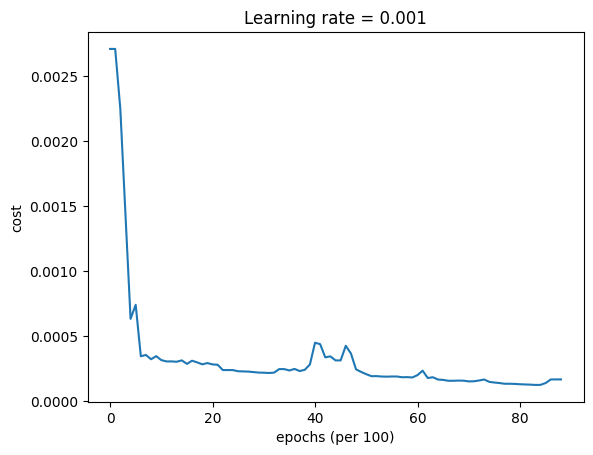

In [11]:

plt.plot(cost1)
plt.ylabel('cost')
plt.xlabel('epochs (per 100)')
plt.title("Learning rate = " + str(lr))
plt.show()

## Predict the val and test set to diagnostic overfitting 

In [12]:
y_pred_val = predict(X_val , y_val , model, activations , way = 'val')

En validacion el modelo logro: cost = 0.266875 — accuracy = 99.00%


In [13]:
y_pred_test = predict(X_test , y_test , model, activations , way = 'test')

En testeo el modelo logro: cost = 0.271343 — accuracy = 98.20%


## Now lets see the ROC curve and clasification report

Classification Report:
               precision    recall  f1-score   support

     Clase 0      0.982     0.996     0.989       820
     Clase 1      0.982     0.917     0.948       180

    accuracy                          0.982      1000
   macro avg      0.982     0.957     0.969      1000
weighted avg      0.982     0.982     0.982      1000



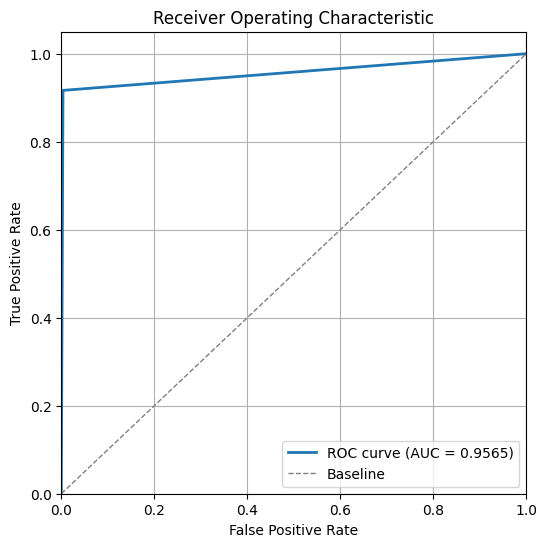

In [14]:

report = classification_report(
    y_test.T,
    y_pred_test.T,
    target_names=['Clase 0', 'Clase 1'],
    digits=3)

print("Classification Report:\n", report)

fpr, tpr, thresholds = roc_curve(y_test.T, y_pred_test.T)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Validation set**  
- Cost: 0.2669  
- Accuracy: 99.0%  

**Test set**  
- Cost: 0.2713  
- Accuracy: 98.2%  

**Classification Report**  
- **Class 0:** Precision 0.982, Recall 0.996, F1-score 0.989 (Support 820)  
- **Class 1:** Precision 0.982, Recall 0.917, F1-score 0.948 (Support 180)  
- **Overall accuracy:** 0.982  
- **Macro average:** Precision 0.982, Recall 0.957, F1-score 0.969  
- **Weighted average:** Precision 0.982, Recall 0.982, F1-score 0.982  

Beyond the raw scores, these results tell us that the network is exceptionally reliable at identifying both churners and non-churners:

- **Robust learning and generalization:**  
  The nearly identical costs (0.2669 vs. 0.2713) and accuracies (99.0% vs. 98.2%) on validation and test sets indicate minimal overfitting. The model has captured true patterns in the data rather than noise.

- **Excellent performance on the majority class (non-churners):**  
  With recall of 0.996, almost every non-churner is correctly identified, minimizing false alarms. High precision (0.982) also shows few non-churners are misclassified as churners.

- **Strong—but slightly lower—detection of churners:**  
  Recall for churners is 0.917, meaning about 8.3% of actual churners slip through undetected. However, precision of 0.982 means that nearly all predicted churners truly churn, which is critical when targeting retention efforts.

- **Balanced trade-off:**  
  The F1-score of 0.948 for churners reflects a solid balance between finding churners and avoiding false positives. This balance ensures that marketing or intervention resources are used efficiently.

- **Business impact:**  
  Catching over 91% of churners with very few false positives translates into more targeted retention campaigns and reduced wasted spend. The model’s stability across splits inspires confidence for deployment.

Overall, the network not only yields stellar metrics but does so in a stable, business-actionable way, particularly by reliably flagging at-risk customers while keeping false-alarm rates minimal.  


***
# Conclutions 

Overall, our scratch-built neural network demonstrates impressive versatility and reliability. It handles both binary classification and true multi-class problems through a softmax output, and its modular components—activations, initializations, optimizers, learning-rate schedules, and L2 regularization—offer a broad hyperparameter space for systematic tuning. Training curves show stable convergence without dramatic oscillations, and the clear, well-organized codebase in `src/` plus accompanying notebooks makes it easy to integrate enhancements like dropout for improved generalization or swap in alternative loss functions and output layers to tackle regression tasks. This lightweight yet powerful framework serves as an excellent foundation for exploring advanced ideas and scaling up to deeper architectures in future work.

## **Pablo Reyes** 